In [1]:
import phyflow as pf
import phyflow.monte_carlo as mc
import phyflow.phy_flow_matching as pfm
from pathlib import Path
from pytorch_lightning import seed_everything
import torch
from torchvision.transforms.v2 import Compose, RandomHorizontalFlip, RandomVerticalFlip
from torch.utils.data import ConcatDataset, DataLoader
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
import matplotlib.pyplot as plt
import time
import logging

In [2]:
trash = []
seed_everything(42, workers=True)
torch.set_float32_matmul_precision('high')
sympy_interp_logger = logging.getLogger("torch.utils._sympy.interp")
sympy_interp_logger.setLevel(logging.ERROR)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

2025-07-04 19:14:46,221 - INFO - Seed set to 42


# System Size Extrapolation Lab

### Prepare the Monte Carlo data of the XY model

#### Validation Data

In [3]:
save_dir_root = './'
xy_generator = mc.MCDataGenerator(sampler_class=mc.XYModel, save_dir_root=save_dir_root)

L_val_list = [16, 32, 64]
T_start_val = 0.1
T_end_val = 2.0
precision_val = 0.05
ensemble_number_val = 1500

2025-07-04 19:14:46,355 - INFO - MCDataGenerator initialized for XYModel with save root: .


In [4]:
measurement_save_path_pt_list = []
config_save_path_pt_list = []

for L_val in L_val_list:
    save_dir_root = Path(save_dir_root)
    sampler_name = mc.XYModel.__name__
    mc_data_dir = save_dir_root / "mc_data"
    sampler_dir = mc_data_dir / sampler_name
    field_config_dir = sampler_dir / "field_config"
    filename_base = f"{sampler_name}_L{L_val}_T{T_start_val:.3f}-{T_end_val:.3f}_prec{precision_val:.3f}_ens{ensemble_number_val}"
    filename_base = filename_base.replace('.', '_')
    config_save_path = field_config_dir / f"{filename_base}_configs.pt"
    measurement_dir = sampler_dir / "measurement"
    measurement_save_path_pt = measurement_dir / f"{filename_base}_measurements.pt"

    config_save_path_pt_list.append(config_save_path)
    measurement_save_path_pt_list.append(measurement_save_path_pt)

# mc_measure_results_val = torch.load(measurement_save_path_pt, map_location='cpu', weights_only=False)

### Prepare the neural network

In [5]:
model_parameter_dict = {
    'in_channels': 1,
    'out_channels': 1,
    'model_channels': 32,
    'downsample_out_ch_mult': (1, 1, 2,),
    'start_attn_level': 2,
    'num_blocks': 1,
    'dropout': 0.1,
    'num_heads': 4,
    'num_groups': 4,
    'num_conditions': 2,
    'emb_dim': 32,
    'padding_mode': 'circular',
}

model = pfm.RoDitUnet(**model_parameter_dict).to(device)

dummy_inputs = {
    'x': torch.randn(32, 1, 32, 32, device="cuda"),
    'time': torch.randn(32, device="cuda"),
    'conditions': [
        torch.randn(32, device="cuda"),
        torch.randn(32, device="cuda"),
    ]
}

pf.profile_model(model, dummy_inputs)

Parameters:                           0.21 M
FLOPs (floating point operations):    975.31 M
Estimated memory usage (params only): 0.81 MB


#### Model Architecture

In [6]:
pf.check_model(model)

RoDitUnet(
  (time_embedder): SinusoidalPosEmb()
  (time_mlp_embedders): MLPEmbedder(
    (mlp_emb_in_layer): Linear(in_features=32, out_features=128, bias=True)
    (mlp_emb_act): SiLU()
    (mlp_emb_out_layer): Linear(in_features=128, out_features=32, bias=True)
  )
  (cond_pos_embedders): ModuleList(
    (0-1): 2 x SinusoidalPosEmb()
  )
  (cond_mlp_embedders): ModuleList(
    (0-1): 2 x MLPEmbedder(
      (mlp_emb_in_layer): Linear(in_features=32, out_features=128, bias=True)
      (mlp_emb_act): SiLU()
      (mlp_emb_out_layer): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (mlp_msa): ConditionalMSAWithRoPE(
    (norm): RMSNorm((32,), eps=1e-06, elementwise_affine=True)
    (seq_expand_proj): Linear(in_features=3, out_features=32, bias=True)
    (qkv_projection): Linear(in_features=32, out_features=96, bias=False)
    (rope): RoPE()
    (head_combine_proj): Linear(in_features=32, out_features=32, bias=True)
    (seq_combine_proj): Linear(in_features=32, out_featu

### Prepare the save path

In [7]:
save_root = './'
save_folder_name = 'system_size_extrapolation_log'
pf.create_directory(root_path=save_root, folder_name=save_folder_name)
fm_save_dir_root = Path(save_root) / save_folder_name

### Prepare the flow matching executor

In [8]:
gradient_accumulation_steps = 4
base_lr = gradient_accumulation_steps * 2e-4
total_epochs = 15
warmup_epochs = 5

# init optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=0.1)

# init scheduler
warmup_scheduler = LinearLR(
    optimizer,
    start_factor=1/gradient_accumulation_steps,
    end_factor=1.0,
    total_iters=warmup_epochs
)

cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=(total_epochs - warmup_epochs),
    eta_min=1e-6
)

scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[warmup_epochs]
)

fmex = pfm.CFMExecutor(
    save_dir_root=fm_save_dir_root,
    model_params=model_parameter_dict,
    model=model,
    model_wrapper=pfm.CFMWrapper,
    optimizer=optimizer,
    lr_scheduler=scheduler,
    device=device,
)

2025-07-04 19:14:55,311 - INFO - Save directory root 'system_size_extrapolation_log' confirmed/created.
2025-07-04 19:14:55,312 - INFO - AutoClip initialized with percentile=10.0, window_size=1000.
2025-07-04 19:14:55,312 - INFO - CFMExecutor initialized. Device: cuda:0
2025-07-04 19:14:55,313 - INFO - Save directory root: system_size_extrapolation_log
2025-07-04 19:14:55,313 - WARNING - Base distribution p0 not provided. Likelihood computation will default to standard Normal or may not be available if data shape is incompatible.


### Train the model

### Sample with the trained model and compare with Monte Carlo

#### Sample at the training size

In [9]:
load_pretrained = True

if load_pretrained:
    fmex.load_checkpoint('./pretrained_models/train_on_xy_L32.pth')
else:
    fmex.load_checkpoint(save_dir_root/f'checkpoints/checkpoint_epoch_{total_epochs:04d}.pth')

2025-07-04 19:14:55,471 - INFO - Loaded AutoClip gradient history from checkpoint.
2025-07-04 19:14:55,472 - INFO - Loaded checkpoint from pretrained_models/train_on_xy_L32.pth. Last completed epoch: 100.
2025-07-04 19:14:55,472 - INFO - Training will resume from epoch 101.
2025-07-04 19:14:55,473 - INFO -   Last recorded average epoch loss: 1.4969
2025-07-04 19:14:55,473 - INFO -   Associated model params from checkpoint: {'in_channels': 1, 'out_channels': 1, 'model_channels': 32, 'downsample_out_ch_mult': (1, 1, 2), 'start_attn_level': 2, 'num_blocks': 1, 'dropout': 0.1, 'num_heads': 4, 'num_groups': 4, 'num_conditions': 2, 'emb_dim': 32, 'padding_mode': 'circular'}


In [10]:
L = 32
Temp_start = 0.1
Temp_end = 2.0
precision = 0.01
num_samples = 500
num_steps = 5
timestep_schedule_factor = 0.6

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = model,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt, shuffle=False)

num_temp: 190
Optimal batch size: 874


In [11]:
torch.cuda.empty_cache()
sol_size_32_start_time = time.time()
sol_size_32 = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_factor=timestep_schedule_factor,
)
sol_size_32_end_time = time.time()
torch.cuda.empty_cache()

sol_size_32_time = sol_size_32_end_time - sol_size_32_start_time

print(f'Solving time for L=32: {sol_size_32_time:.2f} seconds')

2025-07-04 19:14:58,244 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-07-04 19:14:58,245 - INFO - Starting sample generation (solving ODE)...
2025-07-04 19:14:58,245 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-07-04 19:14:58,247 - INFO -   Time Grid (Fixed Steps): [0.0, 0.20000000298023224, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 1.0]
2025-07-04 19:14:58,253 - INFO -   Time Grid (Scheduled for ODE): [0.0, 0.1304347813129425, 0.2857142984867096, 0.4736842215061188, 0.7058824300765991, 1.0]
2025-07-04 19:15:48,514 - INFO - Reshaped generated solutions tensor shape: torch.Size([190, 500, 32, 32])
2025-07-04 19:15:48,515 - INFO - Sample generation finished. Total samples: 95000.


Solving time for L=32: 50.27 seconds


In [12]:
sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

sampler_xy.spins = sol_size_32
trash.append(sol_size_32)

Initialized MonteCarloSampler on device: cuda:0
 L=32, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


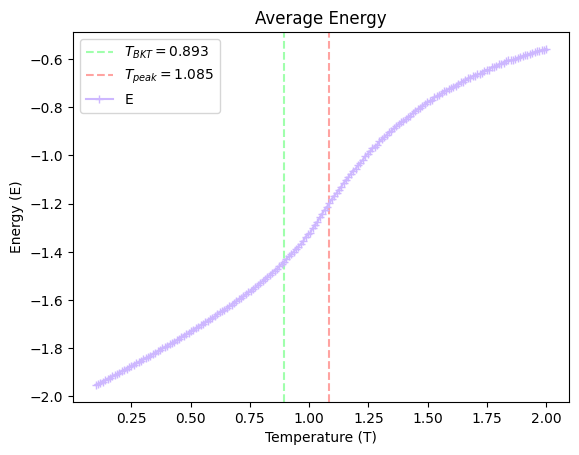

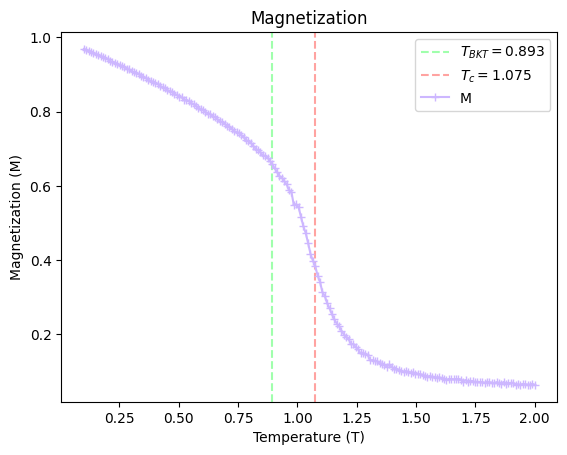

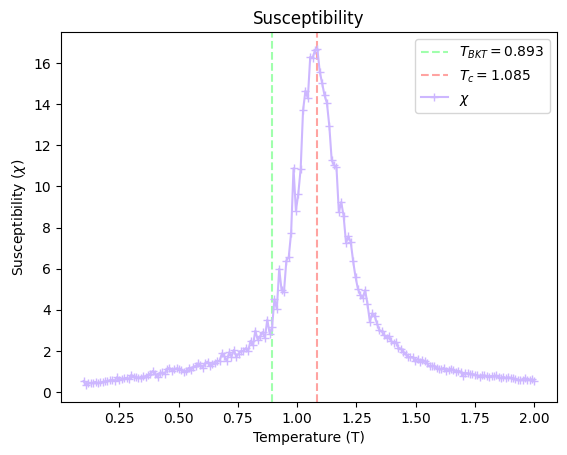

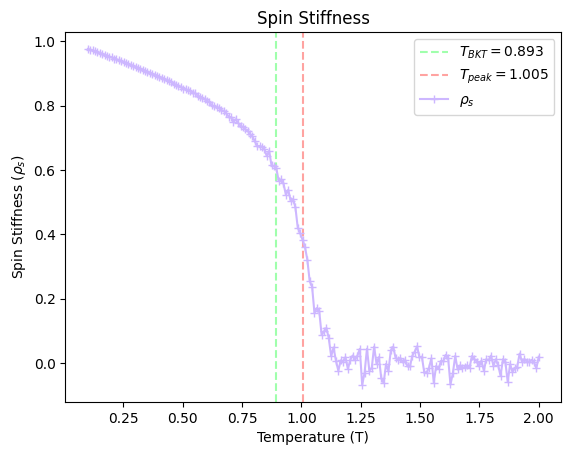

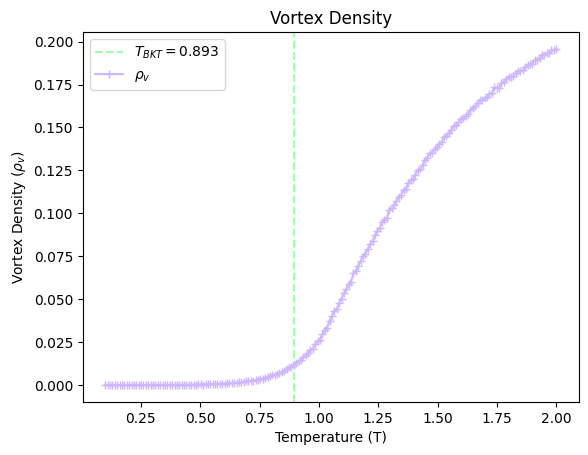

In [13]:
fm_energy_size_32 = sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_magnetization_size_32 = sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_size_32 = sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_size_32 = sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_size_32 = sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

In [14]:
mc_size_32_measure_results = torch.load(
    measurement_save_path_pt_list[L_val_list.index(L)],
    map_location='cpu', weights_only=False
)
mc_size_32_temperature = mc_size_32_measure_results['temperature']
mc_size_32_energy = mc_size_32_measure_results['energy']
mc_size_32_magnetization = mc_size_32_measure_results['magnetization']
mc_size_32_susceptibility = mc_size_32_measure_results['susceptibility']
mc_size_32_stiffness = mc_size_32_measure_results['spin_stiffness']
mc_size_32_vortex_density = mc_size_32_measure_results['vortex_density']

In [15]:
mc_size_32_config_results = torch.load(
    config_save_path_pt_list[L_val_list.index(L)],
    map_location='cpu', weights_only=False
)
mc_size_32_time = mc_size_32_config_results['spend_time']
trash.append(mc_size_32_config_results)
pf.clear_cuda_cache(trash)
trash = []

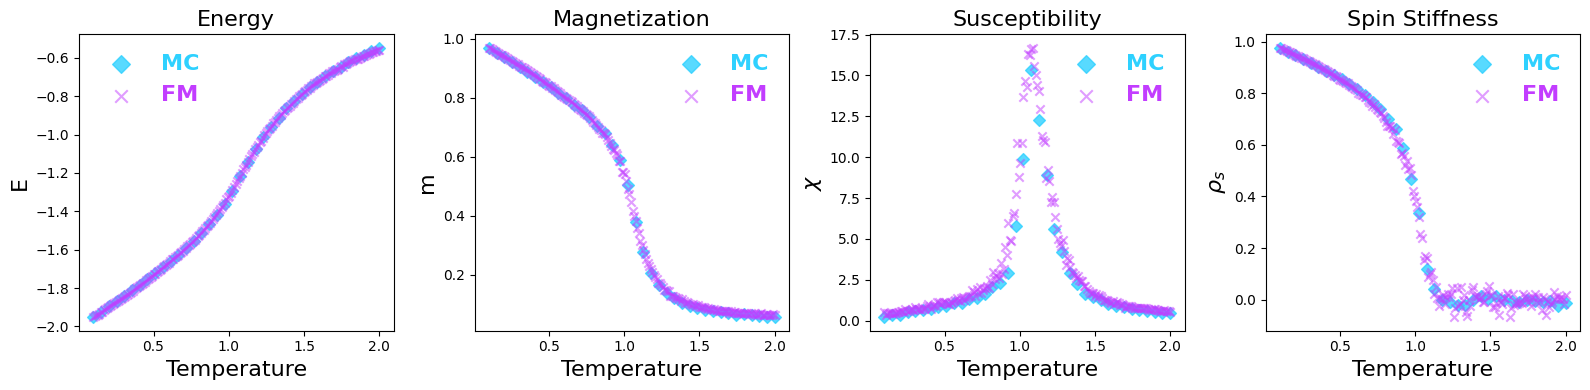

In [16]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
fm_color = '#C23DFF'

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].scatter(mc_size_32_temperature, mc_size_32_energy, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0].scatter(Temp.cpu(), fm_energy_size_32, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[0].set_ylabel('E', fontsize=16)
ax[0].set_title('Energy', fontsize=16)

ax[1].scatter(mc_size_32_temperature, mc_size_32_magnetization, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1].scatter(Temp.cpu(), fm_magnetization_size_32, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[1].set_ylabel('m', fontsize=16)
ax[1].set_title('Magnetization', fontsize=16)

ax[2].scatter(mc_size_32_temperature, mc_size_32_susceptibility, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[2].scatter(Temp.cpu(), fm_susceptibility_size_32, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[2].set_ylabel(r'$\chi$', fontsize=16)
ax[2].set_title('Susceptibility', fontsize=16)

ax[3].scatter(mc_size_32_temperature, mc_size_32_stiffness, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[3].scatter(Temp.cpu(), fm_stiffness_size_32, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[3].set_ylabel(r'$\rho_s$', fontsize=16)
ax[3].set_title('Spin Stiffness', fontsize=16)

for i in range(4):
    ax[i].set_xlabel('Temperature', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_color, fm_color],
        markerscale=1.5,
        frameon=False
    )
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

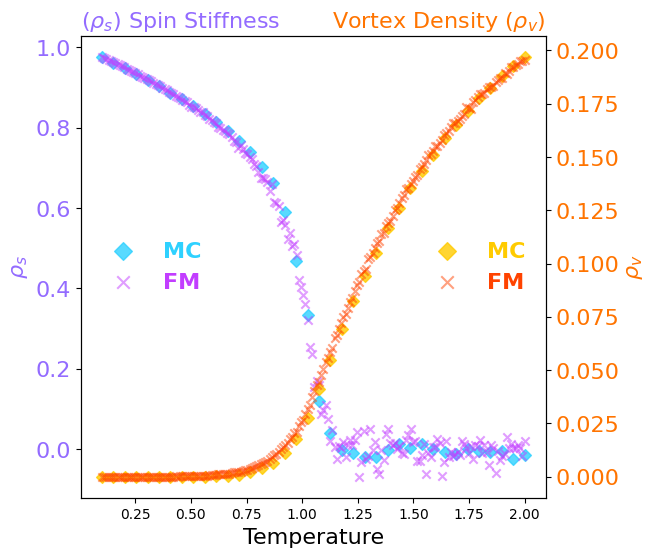

In [17]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

mc_stiffness_color = "#2ED1FF"
fm_stiffness_color = '#C23DFF'

mc_vortex_density_color = "#FFCB00"
fm_vortex_density_color = "#FF4300"

stiffness_axis_color= "#936BFF"
vortex_axis_color = '#FF7400'


fig, ax1 = plt.subplots(figsize=(6, 6))
ax1.scatter(mc_size_32_temperature, mc_size_32_stiffness, marker='D', label='MC', color=mc_stiffness_color, alpha=0.8)
ax1.scatter(Temp.cpu(), fm_stiffness_size_32, marker='x', label='FM', color=fm_stiffness_color, alpha=0.5)
ax1.set_xlabel('Temperature', fontsize=16)
ax1.set_ylabel(r'$\rho_s$', fontsize=16, color=stiffness_axis_color)
ax1.set_title(r'($\rho_s$) Spin Stiffness', fontsize=16, color=stiffness_axis_color, loc='left')
ax1.tick_params(axis='y', labelsize=16, labelcolor=stiffness_axis_color)

ax1.legend(
        loc='center left',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_stiffness_color, fm_stiffness_color],
        markerscale=1.5,
        frameon=False
    )

ax2 = ax1.twinx()
ax2.scatter(mc_size_32_temperature, mc_size_32_vortex_density, marker='D', label='MC', color=mc_vortex_density_color, alpha=0.8)
ax2.scatter(Temp.cpu(), fm_vortex_density_size_32, marker='x', label='FM', color=fm_vortex_density_color, alpha=0.5)
ax2.set_ylabel(r'$\rho_v$', fontsize=16, color=vortex_axis_color)
ax2.set_title(r'Vortex Density ($\rho_v$)', fontsize=16, color=vortex_axis_color, loc='right')
ax2.tick_params(axis='y', labelsize=16, labelcolor=vortex_axis_color)

ax2.legend(
        loc='center right',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_vortex_density_color, fm_vortex_density_color],
        markerscale=1.5,
        frameon=False
    )

plt.show()

### Sample beyond the training size

#### Sample at the smaller size

In [18]:
L = 16
Temp_start = 0.1
Temp_end = 2.0
precision = 0.01
num_samples = 500
num_steps = 5
timestep_schedule_factor = 0.6

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = model,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt, shuffle=False)

num_temp: 190


W0704 19:15:51.892000 153671 site-packages/torch/_dynamo/convert_frame.py:964] [6/8] torch._dynamo hit config.recompile_limit (8)
W0704 19:15:51.892000 153671 site-packages/torch/_dynamo/convert_frame.py:964] [6/8]    function: 'forward' (/mnt/c/Users/ray/Documents/research_project/Flow-to-Field/phyflow/phy_flow_matching/models/rodit_unet.py:773)
W0704 19:15:51.892000 153671 site-packages/torch/_dynamo/convert_frame.py:964] [6/8]    last reason: 6/7: dict.__getitem__(self._modules['adaLN_modulation']._modules['0']._forward_hooks, list(dict.keys(self._modules['adaLN_modulation']._modules['0']._forward_hooks))[0]).__closure__[0].cell_contents == 69504
W0704 19:15:51.892000 153671 site-packages/torch/_dynamo/convert_frame.py:964] [6/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0704 19:15:51.892000 153671 site-packages/torch/_dynamo/convert_frame.py:964] [6/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Optimal batch size: 3426


In [19]:
torch.cuda.empty_cache()
sol_size_16_start_time = time.time()
sol_size_16 = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_factor=timestep_schedule_factor,
)
sol_size_16_end_time = time.time()
torch.cuda.empty_cache()

sol_size_16_time = sol_size_16_end_time - sol_size_16_start_time

print(f'Solving time for L=16: {sol_size_16_time:.2f} seconds')

2025-07-04 19:15:53,464 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-07-04 19:15:53,464 - INFO - Starting sample generation (solving ODE)...
2025-07-04 19:15:53,465 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-07-04 19:15:53,466 - INFO -   Time Grid (Fixed Steps): [0.0, 0.20000000298023224, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 1.0]
2025-07-04 19:15:53,467 - INFO -   Time Grid (Scheduled for ODE): [0.0, 0.1304347813129425, 0.2857142984867096, 0.4736842215061188, 0.7058824300765991, 1.0]
2025-07-04 19:16:08,321 - INFO - Reshaped generated solutions tensor shape: torch.Size([190, 500, 16, 16])
2025-07-04 19:16:08,322 - INFO - Sample generation finished. Total samples: 95000.


Solving time for L=16: 14.86 seconds


In [20]:
sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

sampler_xy.spins = sol_size_16
trash.append(sol_size_16)

Initialized MonteCarloSampler on device: cuda:0
 L=16, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


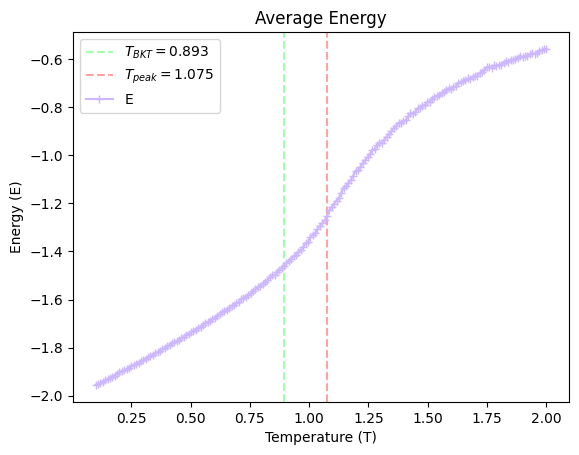

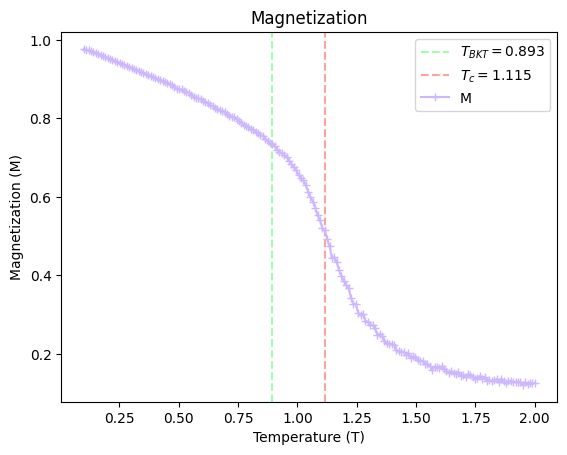

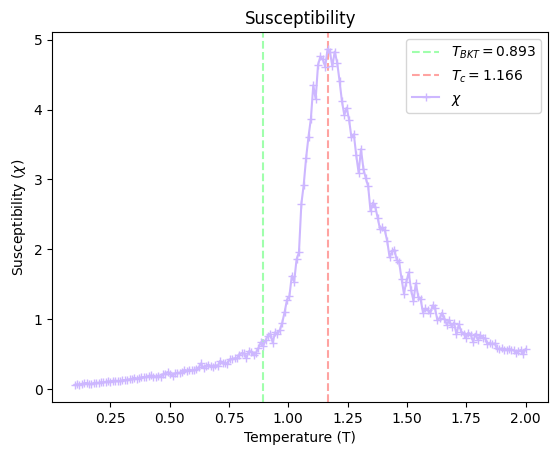

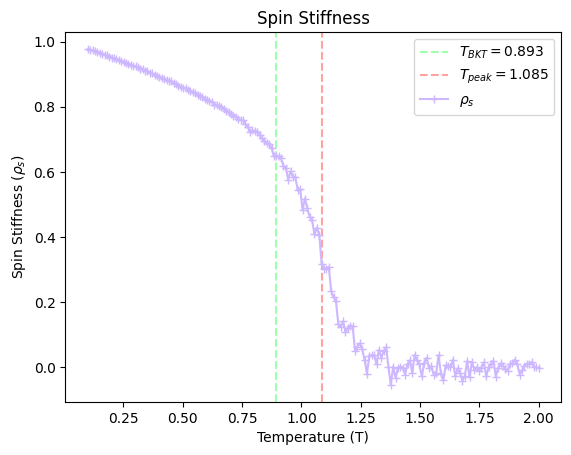

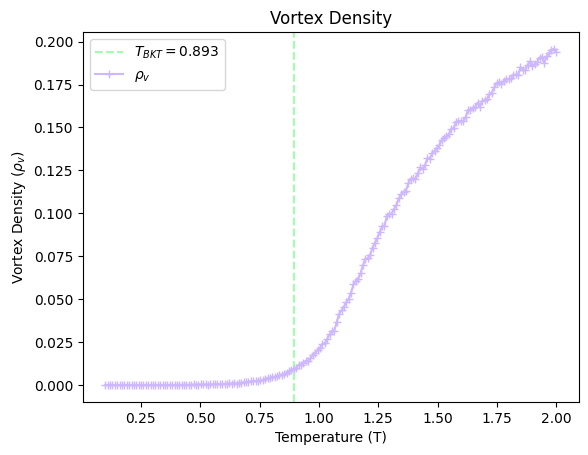

In [21]:
fm_energy_size_16 = sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_magnetization_size_16 = sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_size_16 = sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_size_16 = sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_size_16 = sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

In [22]:
mc_size_16_measure_results = torch.load(
    measurement_save_path_pt_list[L_val_list.index(L)],
    map_location='cpu', weights_only=False
)
mc_size_16_temperature = mc_size_16_measure_results['temperature']
mc_size_16_energy = mc_size_16_measure_results['energy']
mc_size_16_magnetization = mc_size_16_measure_results['magnetization']
mc_size_16_susceptibility = mc_size_16_measure_results['susceptibility']
mc_size_16_stiffness = mc_size_16_measure_results['spin_stiffness']
mc_size_16_vortex_density = mc_size_16_measure_results['vortex_density']

In [23]:
mc_size_16_config_results = torch.load(
    config_save_path_pt_list[L_val_list.index(L)],
    map_location='cpu', weights_only=False
)
mc_size_16_time = mc_size_16_config_results['spend_time']
trash.append(mc_size_16_config_results)
pf.clear_cuda_cache(trash)
trash = []

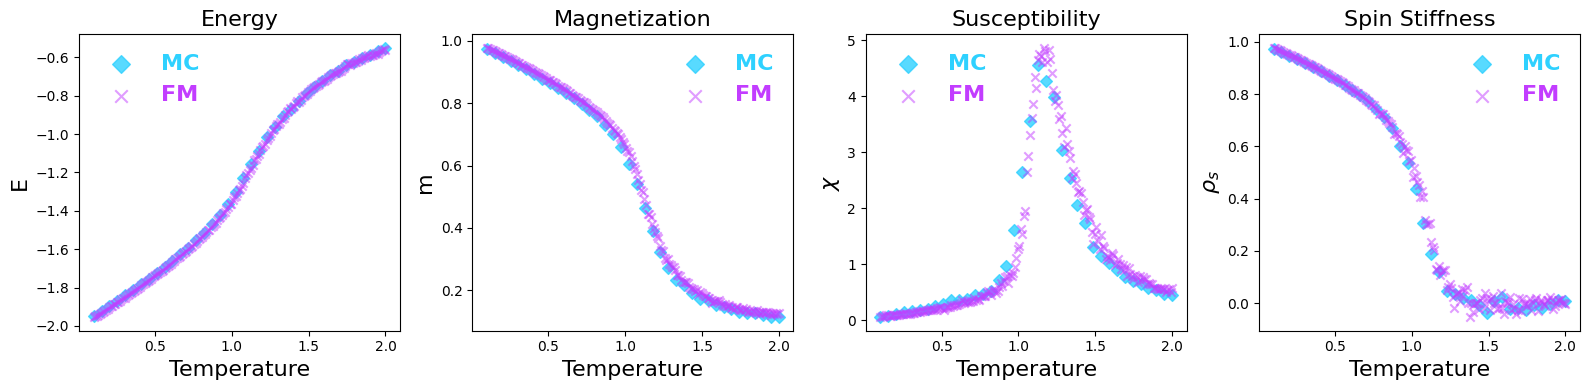

In [24]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
fm_color = '#C23DFF'

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].scatter(mc_size_16_temperature, mc_size_16_energy, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0].scatter(Temp.cpu(), fm_energy_size_16, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[0].set_ylabel('E', fontsize=16)
ax[0].set_title('Energy', fontsize=16)

ax[1].scatter(mc_size_16_temperature, mc_size_16_magnetization, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1].scatter(Temp.cpu(), fm_magnetization_size_16, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[1].set_ylabel('m', fontsize=16)
ax[1].set_title('Magnetization', fontsize=16)

ax[2].scatter(mc_size_16_temperature, mc_size_16_susceptibility, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[2].scatter(Temp.cpu(), fm_susceptibility_size_16, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[2].set_ylabel(r'$\chi$', fontsize=16)
ax[2].set_title('Susceptibility', fontsize=16)

ax[3].scatter(mc_size_16_temperature, mc_size_16_stiffness, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[3].scatter(Temp.cpu(), fm_stiffness_size_16, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[3].set_ylabel(r'$\rho_s$', fontsize=16)
ax[3].set_title('Spin Stiffness', fontsize=16)

for i in range(4):
    ax[i].set_xlabel('Temperature', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_color, fm_color],
        markerscale=1.5,
        frameon=False
    )
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

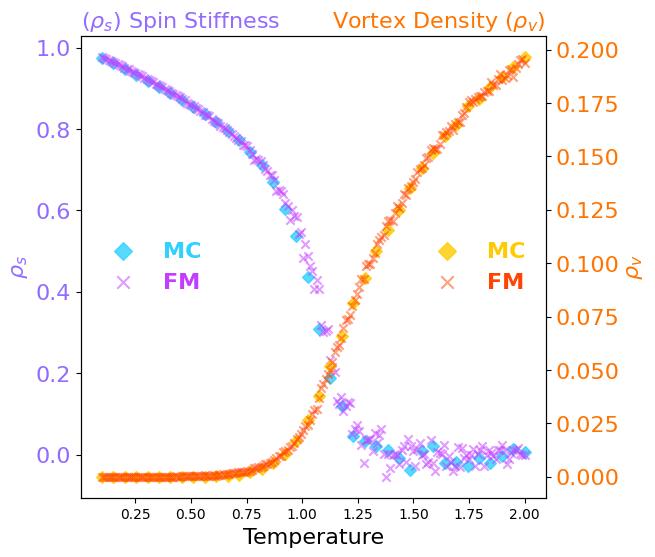

In [25]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

mc_stiffness_color = "#2ED1FF"
fm_stiffness_color = '#C23DFF'

mc_vortex_density_color = "#FFCB00"
fm_vortex_density_color = "#FF4300"

stiffness_axis_color= "#936BFF"
vortex_axis_color = '#FF7400'


fig, ax1 = plt.subplots(figsize=(6, 6))
ax1.scatter(mc_size_16_temperature, mc_size_16_stiffness, marker='D', label='MC', color=mc_stiffness_color, alpha=0.8)
ax1.scatter(Temp.cpu(), fm_stiffness_size_16, marker='x', label='FM', color=fm_stiffness_color, alpha=0.5)
ax1.set_xlabel('Temperature', fontsize=16)
ax1.set_ylabel(r'$\rho_s$', fontsize=16, color=stiffness_axis_color)
ax1.set_title(r'($\rho_s$) Spin Stiffness', fontsize=16, color=stiffness_axis_color, loc='left')
ax1.tick_params(axis='y', labelsize=16, labelcolor=stiffness_axis_color)

ax1.legend(
        loc='center left',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_stiffness_color, fm_stiffness_color],
        markerscale=1.5,
        frameon=False
    )

ax2 = ax1.twinx()
ax2.scatter(mc_size_16_temperature, mc_size_16_vortex_density, marker='D', label='MC', color=mc_vortex_density_color, alpha=0.8)
ax2.scatter(Temp.cpu(), fm_vortex_density_size_16, marker='x', label='FM', color=fm_vortex_density_color, alpha=0.5)
ax2.set_ylabel(r'$\rho_v$', fontsize=16, color=vortex_axis_color)
ax2.set_title(r'Vortex Density ($\rho_v$)', fontsize=16, color=vortex_axis_color, loc='right')
ax2.tick_params(axis='y', labelsize=16, labelcolor=vortex_axis_color)

ax2.legend(
        loc='center right',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_vortex_density_color, fm_vortex_density_color],
        markerscale=1.5,
        frameon=False
    )

plt.show()

#### Sample at the larger size

In [26]:
L = 64
Temp_start = 0.1
Temp_end = 2.0
precision = 0.01
num_samples = 500
num_steps = 5
timestep_schedule_factor = 0.6

num_temp = int((Temp_end-Temp_start)//precision)+1
print(f'num_temp: {num_temp}')

B_opt = pf.estimate_max_batch_size(
    model = model,
    num_data=num_temp * num_samples,
    channels=1,
    height=L,
    width=L,
    time_steps=num_steps,
    num_evals=3,
    device=device,
    use_adjoint=False,
    safety_factor=0.9
)
print(f"Optimal batch size: {B_opt}")

Temp = torch.linspace(Temp_start, Temp_end, steps=num_temp)
x_init = torch.randn((num_temp, num_samples, L, L), dtype=torch.float32)

xy_inference_dataset = mc.MCDataset(data=x_init, labels=Temp)
xy_inference_dataloader = DataLoader(xy_inference_dataset, batch_size=B_opt, shuffle=False)

num_temp: 190


W0704 19:16:11.064000 153671 site-packages/torch/_dynamo/convert_frame.py:964] [7/8] torch._dynamo hit config.recompile_limit (8)
W0704 19:16:11.064000 153671 site-packages/torch/_dynamo/convert_frame.py:964] [7/8]    function: 'forward' (/mnt/c/Users/ray/Documents/research_project/Flow-to-Field/phyflow/phy_flow_matching/models/rodit_unet.py:1012)
W0704 19:16:11.064000 153671 site-packages/torch/_dynamo/convert_frame.py:964] [7/8]    last reason: 7/7: dict.__getitem__(self._modules['adaLN_modulation']._modules['0']._forward_hooks, list(dict.keys(self._modules['adaLN_modulation']._modules['0']._forward_hooks))[0]).__closure__[0].cell_contents == 7377664
W0704 19:16:11.064000 153671 site-packages/torch/_dynamo/convert_frame.py:964] [7/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0704 19:16:11.064000 153671 site-packages/torch/_dynamo/convert_frame.py:964] [7/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
W

Optimal batch size: 220


In [27]:
torch.cuda.empty_cache()
sol_size_64_start_time = time.time()
sol_size_64 = fmex.solve(
    solve_loader=xy_inference_dataloader,
    num_samples=num_samples,
    num_steps=num_steps,
    method='heun3',
    timestep_schedule_factor=timestep_schedule_factor,
)
sol_size_64_end_time = time.time()
torch.cuda.empty_cache()

sol_size_64_time = sol_size_64_end_time - sol_size_64_start_time

print(f'Solving time for L=64: {sol_size_64_time:.2f} seconds')

2025-07-04 19:16:13,788 - INFO - Using the original model's velocity field (via wrapper) for sampling.
2025-07-04 19:16:13,789 - INFO - Starting sample generation (solving ODE)...
2025-07-04 19:16:13,789 - INFO -   Solver: heun3, Time Grid (Original): [0.0, 1.0]
2025-07-04 19:16:13,790 - INFO -   Time Grid (Fixed Steps): [0.0, 0.20000000298023224, 0.4000000059604645, 0.6000000238418579, 0.800000011920929, 1.0]
2025-07-04 19:16:13,791 - INFO -   Time Grid (Scheduled for ODE): [0.0, 0.1304347813129425, 0.2857142984867096, 0.4736842215061188, 0.7058824300765991, 1.0]
2025-07-04 19:19:36,522 - INFO - Reshaped generated solutions tensor shape: torch.Size([190, 500, 64, 64])
2025-07-04 19:19:36,522 - INFO - Sample generation finished. Total samples: 95000.


Solving time for L=64: 202.74 seconds


In [28]:
sampler_xy = mc.XYModel(
    L=L,
    T=Temp,
    device=torch.device(device),
    use_amp=True
)

sampler_xy.spins = sol_size_64
trash.append(sol_size_64)

Initialized MonteCarloSampler on device: cuda:0
 L=64, BatchSize=190, ChainsPerTemp=30, AMP=True, PT=True, LargeSim=False


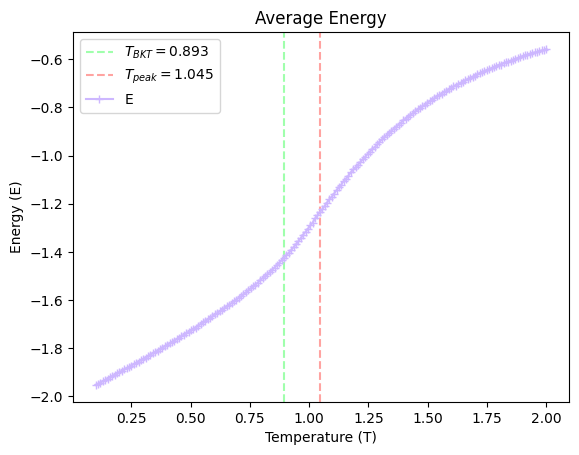

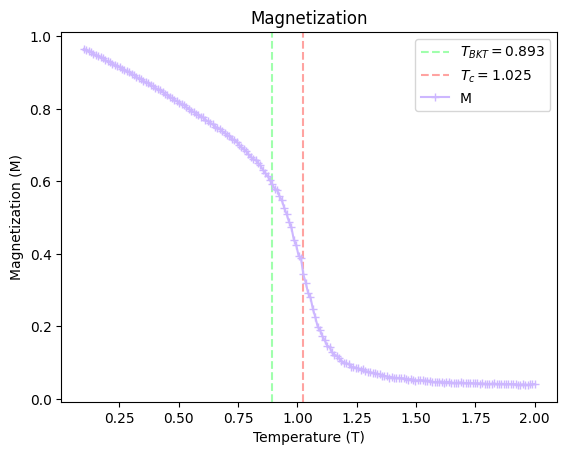

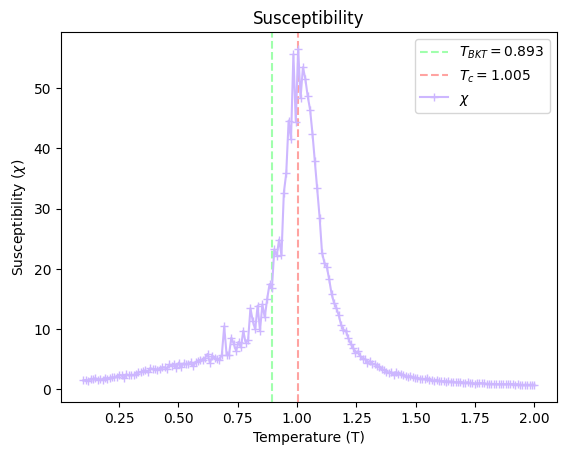

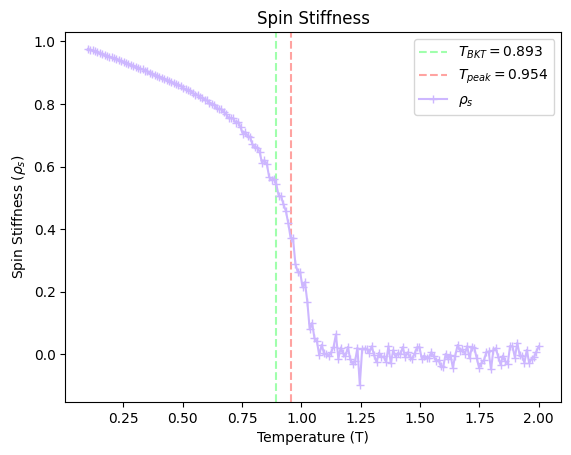

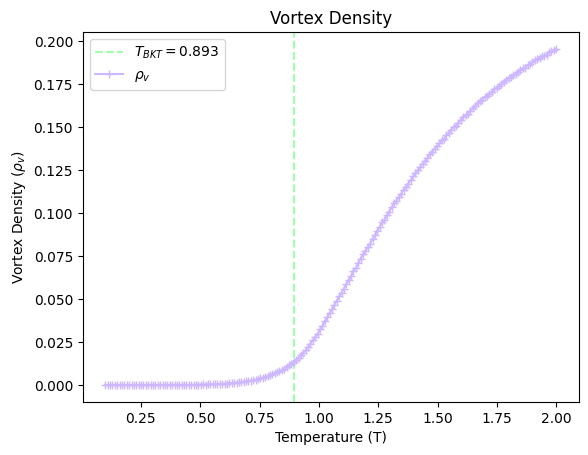

In [29]:
fm_energy_size_64 = sampler_xy.plot_energy(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_magnetization_size_64 = sampler_xy.plot_magnetization(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_susceptibility_size_64 = sampler_xy.plot_susceptibility(
    plot_t_bkt=True,
    plot_peak_line=True,
    return_observation=True
)
fm_stiffness_size_64 = sampler_xy.plot_stiffness(
    plot_t_bkt=True,
    plot_first_derivative_peak=True,
    return_observation=True
)
fm_vortex_density_size_64 = sampler_xy.plot_vortex_density(
    plot_t_bkt=True,
    low_memory=True,
    return_observation=True
)

In [30]:
mc_size_64_measure_results = torch.load(
    measurement_save_path_pt_list[L_val_list.index(L)],
    map_location='cpu', weights_only=False
)
mc_size_64_temperature = mc_size_64_measure_results['temperature']
mc_size_64_energy = mc_size_64_measure_results['energy']
mc_size_64_magnetization = mc_size_64_measure_results['magnetization']
mc_size_64_susceptibility = mc_size_64_measure_results['susceptibility']
mc_size_64_stiffness = mc_size_64_measure_results['spin_stiffness']
mc_size_64_vortex_density = mc_size_64_measure_results['vortex_density']

In [31]:
mc_size_64_config_results = torch.load(
    config_save_path_pt_list[L_val_list.index(L)],
    map_location='cpu', weights_only=False
)
mc_size_64_time = mc_size_64_config_results['spend_time']
trash.append(mc_size_64_config_results)
pf.clear_cuda_cache(trash)
trash = []

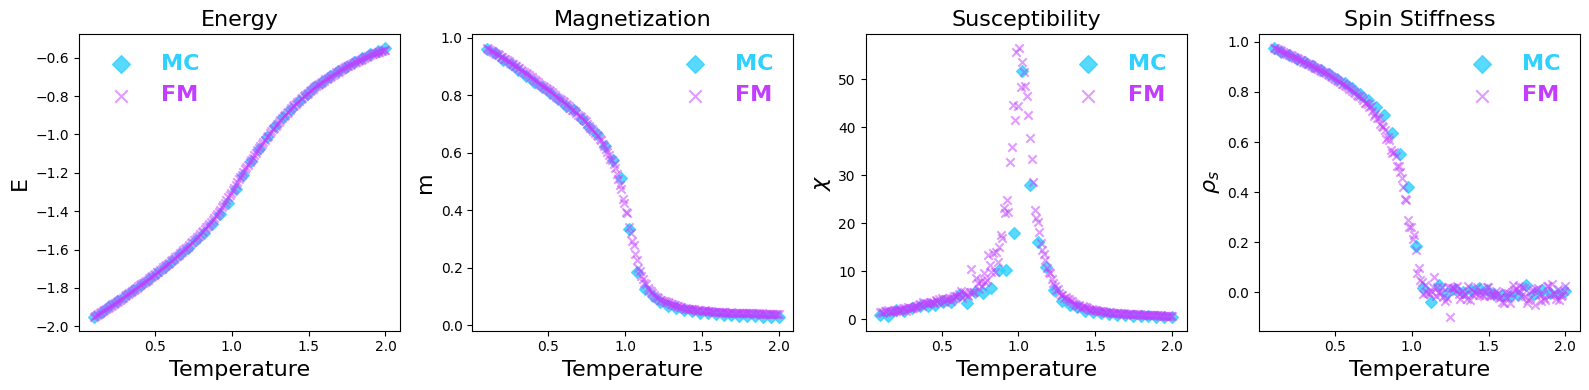

In [32]:
plt.style.use('seaborn-v0_8-pastel')

mc_color = "#2ED1FF"
fm_color = '#C23DFF'

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].scatter(mc_size_64_temperature, mc_size_64_energy, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[0].scatter(Temp.cpu(), fm_energy_size_64, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[0].set_ylabel('E', fontsize=16)
ax[0].set_title('Energy', fontsize=16)

ax[1].scatter(mc_size_64_temperature, mc_size_64_magnetization, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[1].scatter(Temp.cpu(), fm_magnetization_size_64, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[1].set_ylabel('m', fontsize=16)
ax[1].set_title('Magnetization', fontsize=16)

ax[2].scatter(mc_size_64_temperature, mc_size_64_susceptibility, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[2].scatter(Temp.cpu(), fm_susceptibility_size_64, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[2].set_ylabel(r'$\chi$', fontsize=16)
ax[2].set_title('Susceptibility', fontsize=16)

ax[3].scatter(mc_size_64_temperature, mc_size_64_stiffness, marker='D', label='MC', color=mc_color, alpha=0.8)
ax[3].scatter(Temp.cpu(), fm_stiffness_size_64, marker='x', label='FM', color=fm_color, alpha=0.5)
ax[3].set_ylabel(r'$\rho_s$', fontsize=16)
ax[3].set_title('Spin Stiffness', fontsize=16)

for i in range(4):
    ax[i].set_xlabel('Temperature', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_color, fm_color],
        markerscale=1.5,
        frameon=False
    )
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

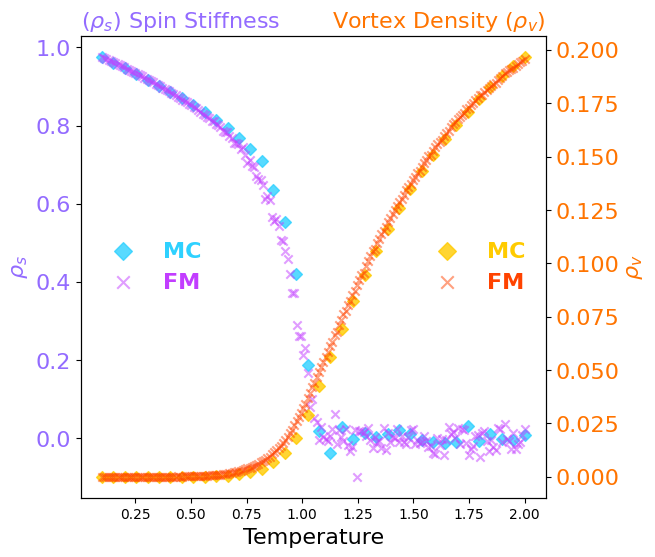

In [33]:
plt.clf()
plt.style.use('seaborn-v0_8-pastel')

mc_stiffness_color = "#2ED1FF"
fm_stiffness_color = '#C23DFF'

mc_vortex_density_color = "#FFCB00"
fm_vortex_density_color = "#FF4300"

stiffness_axis_color= "#936BFF"
vortex_axis_color = '#FF7400'


fig, ax1 = plt.subplots(figsize=(6, 6))
ax1.scatter(mc_size_64_temperature, mc_size_64_stiffness, marker='D', label='MC', color=mc_stiffness_color, alpha=0.8)
ax1.scatter(Temp.cpu(), fm_stiffness_size_64, marker='x', label='FM', color=fm_stiffness_color, alpha=0.5)
ax1.set_xlabel('Temperature', fontsize=16)
ax1.set_ylabel(r'$\rho_s$', fontsize=16, color=stiffness_axis_color)
ax1.set_title(r'($\rho_s$) Spin Stiffness', fontsize=16, color=stiffness_axis_color, loc='left')
ax1.tick_params(axis='y', labelsize=16, labelcolor=stiffness_axis_color)

ax1.legend(
        loc='center left',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_stiffness_color, fm_stiffness_color],
        markerscale=1.5,
        frameon=False
    )

ax2 = ax1.twinx()
ax2.scatter(mc_size_64_temperature, mc_size_64_vortex_density, marker='D', label='MC', color=mc_vortex_density_color, alpha=0.8)
ax2.scatter(Temp.cpu(), fm_vortex_density_size_64, marker='x', label='FM', color=fm_vortex_density_color, alpha=0.5)
ax2.set_ylabel(r'$\rho_v$', fontsize=16, color=vortex_axis_color)
ax2.set_title(r'Vortex Density ($\rho_v$)', fontsize=16, color=vortex_axis_color, loc='right')
ax2.tick_params(axis='y', labelsize=16, labelcolor=vortex_axis_color)

ax2.legend(
        loc='center right',
        prop={'weight': 'bold', 'size': 16},
        labelcolor=[mc_vortex_density_color, fm_vortex_density_color],
        markerscale=1.5,
        frameon=False
    )

plt.show()

### Compare the results between flow matching and Monte Carlo at different system sizes

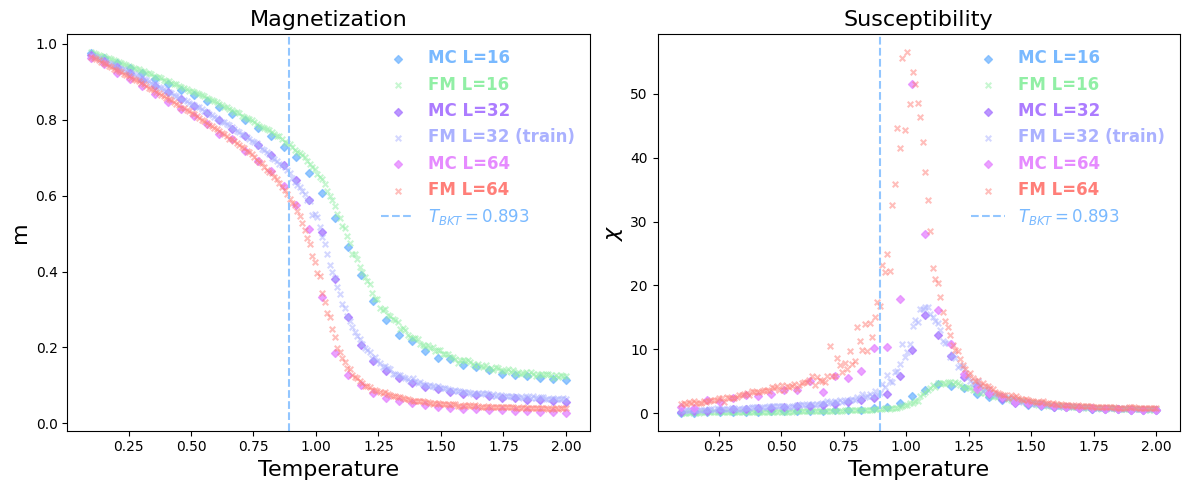

In [34]:
plt.style.use('seaborn-v0_8-pastel')

mc_16_color = "#79B9FF"
fm_16_color = '#91EFA5'

mc_32_color = "#AC7CFF"
fm_32_color = '#AAB1FF'

mc_64_color = "#E68BFF"
fm_64_color = '#FF7F79'

s = 16
tc_bkt = 0.893

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(mc_size_16_temperature, mc_size_16_magnetization, marker='D', label='MC L=16', color=mc_16_color, alpha=0.8, s=s)
ax[0].scatter(Temp.cpu(), fm_magnetization_size_16, marker='x', label='FM L=16', color=fm_16_color, alpha=0.5, s=s)
ax[0].scatter(mc_size_32_temperature, mc_size_32_magnetization, marker='D', label='MC L=32', color=mc_32_color, alpha=0.8, s=s)
ax[0].scatter(Temp.cpu(), fm_magnetization_size_32, marker='x', label='FM L=32 (train)', color=fm_32_color, alpha=0.5, s=s)
ax[0].scatter(mc_size_64_temperature, mc_size_64_magnetization, marker='D', label='MC L=64', color=mc_64_color, alpha=0.8, s=s)
ax[0].scatter(Temp.cpu(), fm_magnetization_size_64, marker='x', label='FM L=64', color=fm_64_color, alpha=0.5, s=s)
ax[0].axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}={tc_bkt:.3f}$')
ax[0].set_ylabel('m', fontsize=16)
ax[0].set_title('Magnetization', fontsize=16)

ax[1].scatter(mc_size_16_temperature, mc_size_16_susceptibility, marker='D', label='MC L=16', color=mc_16_color, alpha=0.8, s=s)
ax[1].scatter(Temp.cpu(), fm_susceptibility_size_16, marker='x', label='FM L=16', color=fm_16_color, alpha=0.5, s=s)
ax[1].scatter(mc_size_32_temperature, mc_size_32_susceptibility, marker='D', label='MC L=32', color=mc_32_color, alpha=0.8, s=s)
ax[1].scatter(Temp.cpu(), fm_susceptibility_size_32, marker='x', label='FM L=32 (train)', color=fm_32_color, alpha=0.5, s=s)
ax[1].scatter(mc_size_64_temperature, mc_size_64_susceptibility, marker='D', label='MC L=64', color=mc_64_color, alpha=0.8, s=s)
ax[1].scatter(Temp.cpu(), fm_susceptibility_size_64, marker='x', label='FM L=64', color=fm_64_color, alpha=0.5, s=s)
ax[1].axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}={tc_bkt:.3f}$')
ax[1].set_ylabel(r'$\chi$', fontsize=16)
ax[1].set_title('Susceptibility', fontsize=16)

for i in range(2):
    ax[i].set_xlabel('Temperature', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 12},
        labelcolor=[mc_16_color, fm_16_color, mc_32_color, fm_32_color, mc_64_color, fm_64_color],
        markerscale=1.0,
        frameon=False
    )
plt.tight_layout()
plt.show()

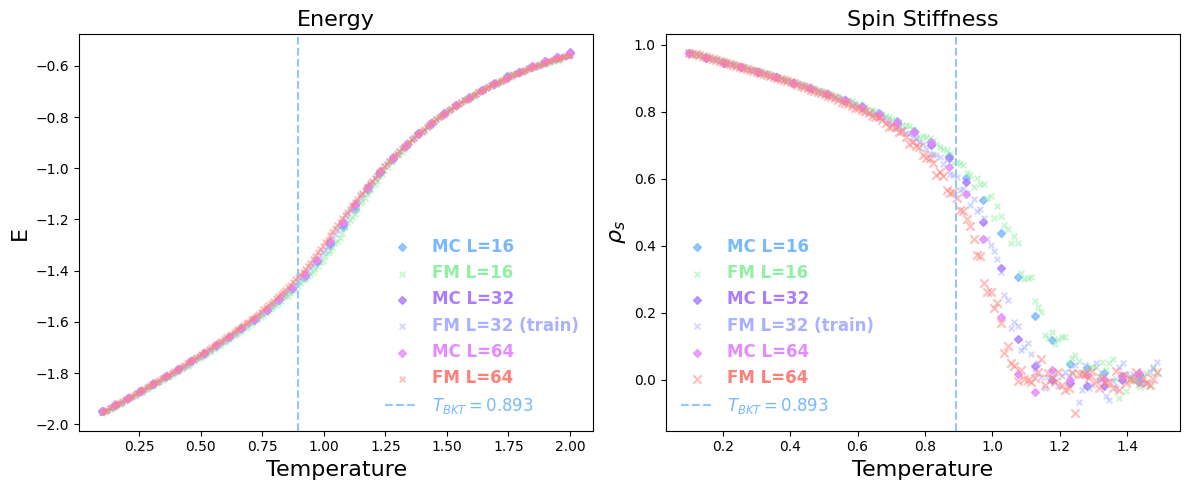

In [35]:
plt.style.use('seaborn-v0_8-pastel')

mc_16_color = "#79B9FF"
fm_16_color = '#91EFA5'

mc_32_color = "#AC7CFF"
fm_32_color = '#AAB1FF'

mc_64_color = "#E68BFF"
fm_64_color = '#FF7F79'

s = 16

fm_Temp_cpu = Temp.cpu()
max_temp = 1.5
mc_max_temp_index = len(mc_size_16_temperature[mc_size_16_temperature < max_temp]) - 1
fm_max_temp_index = len(fm_Temp_cpu[fm_Temp_cpu < max_temp]) - 1
tc_bkt = 0.893

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(mc_size_16_temperature, mc_size_16_energy, marker='D', label='MC L=16', color=mc_16_color, alpha=0.8, s=s)
ax[0].scatter(Temp.cpu(), fm_energy_size_16, marker='x', label='FM L=16', color=fm_16_color, alpha=0.5, s=s)
ax[0].scatter(mc_size_32_temperature, mc_size_32_energy, marker='D', label='MC L=32', color=mc_32_color, alpha=0.8, s=s)
ax[0].scatter(Temp.cpu(), fm_energy_size_32, marker='x', label='FM L=32 (train)', color=fm_32_color, alpha=0.5, s=s)
ax[0].scatter(mc_size_64_temperature, mc_size_64_energy, marker='D', label='MC L=64', color=mc_64_color, alpha=0.8, s=s)
ax[0].scatter(Temp.cpu(), fm_energy_size_64, marker='x', label='FM L=64', color=fm_64_color, alpha=0.5, s=s)
ax[0].axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}={tc_bkt:.3f}$')
ax[0].set_ylabel('E', fontsize=16)
ax[0].set_title('Energy', fontsize=16)

ax[1].scatter(mc_size_16_temperature[:mc_max_temp_index], mc_size_16_stiffness[:mc_max_temp_index], marker='D', label='MC L=16', color=mc_16_color, alpha=0.8, s=s)
ax[1].scatter(fm_Temp_cpu[:fm_max_temp_index], fm_stiffness_size_16[:fm_max_temp_index], marker='x', label='FM L=16', color=fm_16_color, alpha=0.5, s=s)
ax[1].scatter(mc_size_32_temperature[:mc_max_temp_index], mc_size_32_stiffness[:mc_max_temp_index], marker='D', label='MC L=32', color=mc_32_color, alpha=0.8, s=s)
ax[1].scatter(fm_Temp_cpu[:fm_max_temp_index], fm_stiffness_size_32[:fm_max_temp_index], marker='x', label='FM L=32 (train)', color=fm_32_color, alpha=0.5, s=s)
ax[1].scatter(mc_size_64_temperature[:mc_max_temp_index], mc_size_64_stiffness[:mc_max_temp_index], marker='D', label='MC L=64', color=mc_64_color, alpha=0.8, s=s)
ax[1].scatter(fm_Temp_cpu[:fm_max_temp_index], fm_stiffness_size_64[:fm_max_temp_index], marker='x', label='FM L=64', color=fm_64_color, alpha=0.5)
ax[1].axvline(tc_bkt, linestyle='--', label=f'$T_{{BKT}}={tc_bkt:.3f}$')
ax[1].set_ylabel(r'$\rho_s$', fontsize=16)
ax[1].set_title('Spin Stiffness', fontsize=16)

for i in range(2):
    ax[i].set_xlabel('Temperature', fontsize=16)
    ax[i].legend(
        prop={'weight': 'bold', 'size': 12},
        labelcolor=[mc_16_color, fm_16_color, mc_32_color, fm_32_color, mc_64_color, fm_64_color],
        markerscale=1.0,
        frameon=False,
        loc='lower right' if i == 0 else 'lower left',
    )
plt.tight_layout()
plt.show()

### Error analysis.

In [36]:
def mse_mae_estimator(fm_data_list, mc_data_list):
    """
    Calculate the MSE and MAE between flow matching and Monte Carlo data.

    Args:
        fm_data_list (list): List of flow matching data tensors.
        mc_data_list (list): List of Monte Carlo data tensors.

    Returns:
        tuple: MSE and MAE values.
    """
    mse_list = []
    mae_list = []

    for fm_data, mc_data in zip(fm_data_list, mc_data_list):
        fm_tensor = torch.tensor(fm_data[::5])  # Reduce by factor of 5
        mc_tensor = torch.tensor(mc_data)

        mse = torch.nn.functional.mse_loss(fm_tensor, mc_tensor)
        mae = torch.nn.functional.l1_loss(fm_tensor, mc_tensor)

        mse_list.append(mse.item())
        mae_list.append(mae.item())

    return mse_list, mae_list

In [37]:
fm_energy_list = [
    fm_energy_size_16,
    fm_energy_size_32,
    fm_energy_size_64,
]
mc_energy_list = [
    mc_size_16_energy,
    mc_size_32_energy,
    mc_size_64_energy
]
mse_energy, mae_energy = mse_mae_estimator(fm_energy_list, mc_energy_list)

fm_stiffness_list = [
    fm_stiffness_size_16,
    fm_stiffness_size_32,
    fm_stiffness_size_64,
]
mc_stiffness_list = [
    mc_size_16_stiffness,
    mc_size_32_stiffness,
    mc_size_64_stiffness
]
mse_stiffness, mae_stiffness = mse_mae_estimator(fm_stiffness_list, mc_stiffness_list)

fm_magnetization_list = [
    fm_magnetization_size_16,
    fm_magnetization_size_32,
    fm_magnetization_size_64,
]
mc_magnetization_list = [
    mc_size_16_magnetization,
    mc_size_32_magnetization,
    mc_size_64_magnetization
]
mse_magnetization, mae_magnetization = mse_mae_estimator(fm_magnetization_list, mc_magnetization_list)

fm_susceptibility_list = [
    fm_susceptibility_size_16,
    fm_susceptibility_size_32,
    fm_susceptibility_size_64,
]
mc_susceptibility_list = [
    mc_size_16_susceptibility,
    mc_size_32_susceptibility,
    mc_size_64_susceptibility
]
mse_susceptibility, mae_susceptibility = mse_mae_estimator(fm_susceptibility_list, mc_susceptibility_list)

fm_vortex_density_list = [
    fm_vortex_density_size_16,
    fm_vortex_density_size_32,
    fm_vortex_density_size_64,
]
mc_vortex_density_list = [
    mc_size_16_vortex_density,
    mc_size_32_vortex_density,
    mc_size_64_vortex_density
]
mse_vortex_density, mae_vortex_density = mse_mae_estimator(fm_vortex_density_list, mc_vortex_density_list)

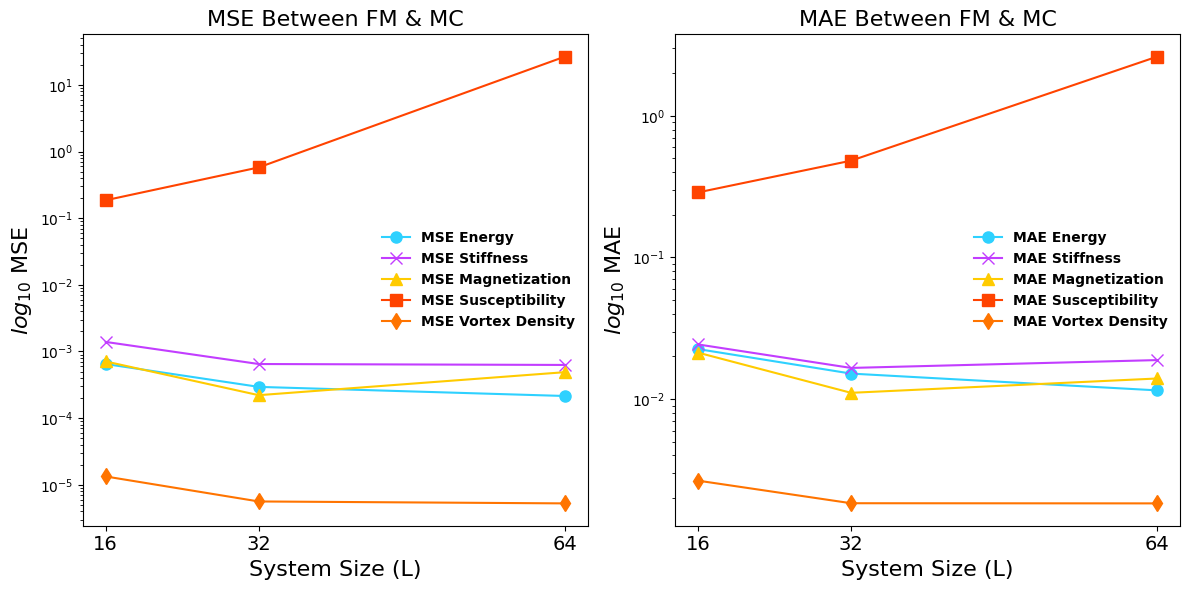

In [41]:
system_size_list = [
    16,
    32,
    64
]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(system_size_list, mse_energy, marker='o', label='MSE Energy', color='#2ED1FF', markersize=8)
ax[0].plot(system_size_list, mse_stiffness, marker='x', label='MSE Stiffness', color='#C23DFF', markersize=8)
ax[0].plot(system_size_list, mse_magnetization, marker='^', label='MSE Magnetization', color='#FFCB00', markersize=8)
ax[0].plot(system_size_list, mse_susceptibility, marker='s', label='MSE Susceptibility', color='#FF4300', markersize=8)
ax[0].plot(system_size_list, mse_vortex_density, marker='d', label='MSE Vortex Density', color='#FF7400', markersize=8)
ax[0].set_xlabel('System Size (L)', fontsize=16)
ax[0].set_ylabel(r'$log_{10}$ MSE', fontsize=16)
ax[0].set_title('MSE Between FM & MC', fontsize=16)
ax[0].set_xticks(system_size_list)
ax[0].set_xticklabels(system_size_list, fontsize=14)
ax[0].set_yscale('log')
ax[0].legend(
    prop={'weight': 'bold', 'size': 10},
    loc='right',
    frameon=False
)

ax[1].plot(system_size_list, mae_energy, marker='o', label='MAE Energy', color='#2ED1FF', markersize=8)
ax[1].plot(system_size_list, mae_stiffness, marker='x', label='MAE Stiffness', color='#C23DFF', markersize=8)
ax[1].plot(system_size_list, mae_magnetization, marker='^', label='MAE Magnetization', color='#FFCB00', markersize=8)
ax[1].plot(system_size_list, mae_susceptibility, marker='s', label='MAE Susceptibility', color='#FF4300', markersize=8)
ax[1].plot(system_size_list, mae_vortex_density, marker='d', label='MAE Vortex Density', color='#FF7400', markersize=8)
ax[1].set_xlabel('System Size (L)', fontsize=16)
ax[1].set_ylabel(r'$log_{10}$ MAE', fontsize=16)
ax[1].set_title('MAE Between FM & MC', fontsize=16)
ax[1].set_xticks(system_size_list)
ax[1].set_xticklabels(system_size_list, fontsize=14)
ax[1].set_yscale('log')
ax[1].legend(
    prop={'weight': 'bold', 'size': 10},
    loc='right',
    frameon=False
)

plt.tight_layout()
plt.show()

### Compare the simulation time between flow matching and Monte Carlo at different system sizes

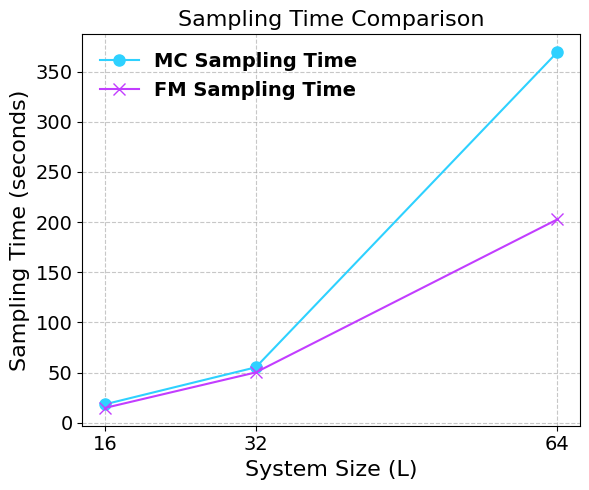

In [39]:
system_size_list = [
    16,
    32,
    64
]
mc_sample_time_list = [
    mc_size_16_time,
    mc_size_32_time,
    mc_size_64_time
]
fm_sample_time_list = [
    sol_size_16_time,
    sol_size_32_time,
    sol_size_64_time
]

plt.figure(figsize=(6, 5))
plt.plot(system_size_list, mc_sample_time_list, marker='o', label='MC Sampling Time', color='#2ED1FF', markersize=8)
plt.plot(system_size_list, fm_sample_time_list, marker='x', label='FM Sampling Time', color='#C23DFF', markersize=8)
plt.xlabel('System Size (L)', fontsize=16)
plt.ylabel('Sampling Time (seconds)', fontsize=16)
plt.title('Sampling Time Comparison', fontsize=16)
plt.xticks(system_size_list, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(
    prop={'weight': 'bold', 'size': 14},
    loc='upper left',
    frameon=False
)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()